# This script is a small-scale version of the periodic/aperiodic alvinocarid dispersal at depth simulations for the larger extent of the Pacific

In [4]:

import pymbolic
import geos
import proj
import netCDF4
from netCDF4 import Dataset,num2date 
import parcels as py
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, AdvectionRK4_3D, AdvectionDiffusionM1, ErrorCode, ParcelsRandom, Variable, VectorField, DiffusionUniformKh, plotTrajectoriesFile
import numpy as np
import math
from datetime import datetime
from datetime import timedelta
from operator import attrgetter
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

from copy import copy
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from IPython.display import Image

import itertools
import random

import cftime

from scipy import interpolate #Solution to 'AttributeError: ErrorInterpolation'?
import os

import matplotlib as mpl
import cmocean
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, writers, PillowWriter
from IPython.display import HTML
import matplotlib.cm as cm
from scipy.stats import gaussian_kde



In [6]:
print(py.__version__)


2.3.0


In [79]:
#!find ../MERCATOR_pacific -type f -size -332c #-delete

## Specify the features of this specific run for filenaming

In [80]:
#runID = "tst_p_1"
#runID = "tst_p_5"
#runID = "tst_p_10"
#runID = "tst_a_1"
runID = "tst_a_5"
#runID = "tst_a_10"

r_depth = 500

## Set number of Particles: release abundance and frequency



In [81]:

#Total larval release time in years and days (needs to be lower than runtime)
rel_time= 20
#rel_time= 5* 365

#Total runtime
runtime = rel_time +300

#number of dates to release particles
#Aperiodic (March) vs Periodic
arel_days= rel_time
prel_days= (rel_time/365) * 31
#prel_days = 31

#number of particles  release occurences (once every 6 hours)
a_n = arel_days *4
p_n = prel_days *4

# The number of particles to release at each occurence is adjusted 
#so that periodic and aperiodic have a similar total
ap_dif = prel_days /arel_days 
p_cloud= 300
#p_cloud= 300

a_cloud =p_cloud*ap_dif
a_cloud = int(a_cloud)

a_cloud

25

In [82]:
#print('Periodic surface dispersal (',runID,'):',prel_days *p_cloud,'total particles released 100 metres above vent',p_cloud,' released every day in March (',prel_days, 'days) over',runtime,'days')

print('Aperiodic surface dispersal (',runID,'):',a_n *a_cloud,'total particles released 100 metres above a single source site.',a_cloud,' released every 6 hours (',a_n, ') over',runtime,'days. Equal to',71*(a_n *a_cloud),'particles released from all source sites')


Aperiodic surface dispersal ( tst_a_5 ): 2000 total particles released 100 metres above a single source site. 25  released every 6 hours ( 80 ) over 320 days. Equal to 142000 particles released from all source sites


## Select vent site

In [83]:
#v=int(sys.argv[1]) #Iteratively select vents

v = 53 #  example for testing. 17 = Izena = release depth issue example

## Import Data

In [84]:
#Import location of vent data
vent_sites=pd.read_csv('data/source_sites.csv', index_col = 'vent')
vent_sites

lat       lon  depth
vent                                              
13 N Ridge Site           13.0987  143.6886   3036
Alice Springs Field       18.2103  144.7073   3640
Bayonnaise Knoll caldera  31.9667  139.7333    900
Burke                     18.1090  144.4320   3660
Chamorro volcano          20.8100  144.7050    896
...                           ...       ...    ...
TOTO Caldera              12.7167  143.5333   2960
W Syoyo                   22.5080  142.5330   2150
West Rota volcano         14.3250  144.8330   1150
Yokosuka                  25.2638  124.3733   2190
Yoron Hole                27.4916  127.5333    590

[69 rows x 3 columns]

In [85]:
vent_name=str(vent_sites.index[v])
v_name = vent_name.replace(" ", "_")

v_name

'Snail'

In [86]:
data_path = '../MERCATOR_pacific/'

merc_egu = xr.open_dataset(data_path + 'glorys12v1_p_1997-01-01T12:00:00.000000000_U.nc')
merc_egv = xr.open_dataset(data_path + 'glorys12v1_p_1997-01-01T12:00:00.000000000_V.nc')
merc_egt = xr.open_dataset(data_path + 'glorys12v1_p_1997-01-01T12:00:00.000000000_T.nc')
merc_egw = xr.open_dataset(data_path + 'glorys12v1_p_1997-01-01T12:00:00.000000000_W.nc')

merc_egw


<xarray.Dataset>
Dimensions:       (y: 1750, x: 1550, depthw: 50)
Coordinates:
    nav_lon       (y, x) float32 ...
  * depthw        (depthw) float32 0.0 1.011 2.086 ... 5.052e+03 5.5e+03
  * x             (x) int32 451 452 453 454 455 456 ... 1996 1997 1998 1999 2000
  * y             (y) int32 751 752 753 754 755 756 ... 2496 2497 2498 2499 2500
    nav_lat       (y, x) float32 ...
    time_counter  datetime64[ns] ...
Data variables:
    vovecrtz      (depthw, y, x) float32 ...
Attributes:
    Conventions:  CF-1.0
    file_name:    GLORYS12V1_y2020m05d30_gridW.nc
    institution:  MERCATOR OCEAN
    source:       NEMO
    TimeStamp:    2021-SEP-02 22:10:58 GMT-0000
    references:   http://www.mercator-ocean.eu

In [87]:
hgr = xr.open_dataset(data_path +'glorys12v1_p_hgr.nc')
zgr = xr.open_dataset(data_path +'glorys12v1_p_zgr.nc')

glamt = hgr.glamt[0,:,:].values
gphit = hgr.gphit[0,:,:].values

## Designate the netcdf file(s) that will act as the fieldset

In [88]:
# The time varaible in these files is nmot formated correctly so an array of dates is created manually
#timestamps = np.expand_dims(np.arange(np.datetime64('1996-12-29'), np.datetime64('2017-12-30')),axis=1)
#timestamps = np.expand_dims(np.arange(np.datetime64('1997-01-01'), np.datetime64('1998-01-01')),axis=1)
#timestamps = np.expand_dims(np.arange(np.datetime64('1996-12-29'), np.datetime64('2000-01-01')),axis=1)
timestamps = np.expand_dims(np.arange(np.datetime64('1996-12-29'), np.datetime64('2003-01-20')),axis=1)


#Specify the location of the files that contain the variables (3D velocity and Temperature)
ufiles = sorted(glob(data_path+'glorys12v1_p_*U.nc'))
vfiles = sorted(glob(data_path+'glorys12v1_p_*V.nc'))
wfiles = sorted(glob(data_path+'glorys12v1_p_*W.nc'))
tfiles = sorted(glob(data_path+'glorys12v1_p_*T.nc'))

#Use the Static file that specifies the coordinates of these variable 
# more infor at https://www.mercator-ocean.eu/static-files-description/
mesh_mask = '../MERCATOR_pacific/glorys12v1_p_hgr.nc'

filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
             'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles},
             'T': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': tfiles}}

variables = {'U': 'vozocrtx',
             'V': 'vomecrty',
             'W': 'vovecrtz',
             'T': 'votemper'}

dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'T': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}}
#incorporate the manual timestamp here and mask the arbitrary null value (-2000)
fieldset = FieldSet.from_nemo(filenames, variables, dimensions,vmin=-2000, timestamps = timestamps,allow_time_extrapolation=True)



In [110]:
len(ufiles)-(365*5+300)

88

In [89]:
lons = fieldset.U.lon
lats = fieldset.U.lat
depths = fieldset.U.depth

fieldmesh_x = lons
fieldmesh_y = lats
fieldmesh_z = depths
fieldmesh_x.shape

(1750, 1550)

## Create a vent site and ID fieldset

In [90]:
dist = (1/12+0.00000001)/2 #The size of the grid cell (1/12 a degree)


#create vent ID
vent_sites['ID'] = range(1, len(vent_sites) + 1)
vent = vent_sites.iloc[0]

# Find absolute difference between requested point and the grid coordinates.
abslat = np.abs(hgr.gphit - vent.lat)
abslon = np.abs(hgr.glamt - vent.lon)

# Create grid of the maximum values of the two absolute grids
c = np.maximum(abslon, abslat)

np.where(c == np.min(c))

ventloc= np.where(c == np.min(c))
ventloc = ventloc[1:]
vx,vy= int(ventloc[0]),int(ventloc[1])

ventmap= np.logical_and(np.ma.masked_where(glamt == glamt[vx,vy],glamt).mask,
np.ma.masked_where(gphit == gphit[vx,vy], gphit).mask)

ventint= ventmap.astype('int')
ventID = np.where(ventint > 0, vent.ID, ventint)


In [91]:
for i in range(1,len(vent_sites)):
    vent = vent_sites.iloc[i]
    #To start make a settlement mask for a single vent site
    # Find absolute difference between requested point and the grid coordinates.
    abslat = np.abs(hgr.gphit - vent.lat)
    abslon = np.abs(hgr.glamt - vent.lon)

    # Create grid of the maximum values of the two absolute grids
    c = np.maximum(abslon, abslat)

    np.where(c == np.min(c))

    ventloc= np.where(c == np.min(c))
    ventloc = ventloc[1:]
    vx,vy= int(ventloc[0]),int(ventloc[1])

    ventmap_i= np.logical_and(np.ma.masked_where(glamt == glamt[vx,vy],glamt).mask,
                            np.ma.masked_where(gphit == gphit[vx,vy], gphit).mask)

    ventint_i= ventmap_i.astype('int')
    ventID_i = np.where(ventint_i > 0, vent.ID, ventint_i)
    ventID = np.maximum(ventID, ventID_i)
    

In [92]:
#Add ID mask
fieldset.add_field(Field('settle_ID', ventID, lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, mesh='spherical',interp_method='nearest')) # Add the settlement cells to the field


## Extract bathymetry values for each vent site

In [93]:
bathyw = zgr.hdepw[0,:,:]
bathy_table=np.empty((1,3))

In [103]:
r_depth = 1000

In [104]:
for i in range(0,len(vent_sites)):
    vent = vent_sites.iloc[i]
    vent_name=str(vent_sites.index[i])

# Find absolute difference between requested point and the grid coordinates.
    abslat = np.abs(hgr.gphit - vent.lat)
    abslon = np.abs(hgr.glamt - vent.lon)

# Create grid of the maximum values of the two absolute grids
    c = np.maximum(abslon, abslat)



    ventloc= np.where(c == np.min(c))
    ventloc = ventloc[1:]
    vx,vy= int(ventloc[0]),int(ventloc[1])
    
    v_bathy=int(zgr.hdepw[0,vx,vy])
    bathy_table=np.vstack([bathy_table,(vent_name,vent_sites.depth[i],v_bathy)])
    if v_bathy<=r_depth:
        print("dispersal too deep for bathymetry at",vent_name,", FAILED")
    else:
        print("execute parcels",vent_name)

execute parcels 13 N Ridge Site
execute parcels Alice Springs Field
execute parcels Bayonnaise Knoll caldera
execute parcels Burke
execute parcels Chamorro volcano
dispersal too deep for bathymetry at Daiichi-Amami knoll , FAILED
execute parcels Daikoku volcano
execute parcels Daisan-Kume Knoll
execute parcels Doyo Seamount
dispersal too deep for bathymetry at East Diamante volcano , FAILED
dispersal too deep for bathymetry at Esmeralda Bank , FAILED
execute parcels Forecast
execute parcels Formosa Ridge (Site F)
execute parcels Fukujin volcano
execute parcels Futagoyama
execute parcels Hafa Adai
execute parcels Higa
execute parcels Higashi Aogashima
execute parcels Higashi-Ensei
execute parcels Irabu Knoll
execute parcels Izena Cauldron
execute parcels Kaikata Seamount
execute parcels Kasuga 2 Seamount
execute parcels Kasuga 3 Seamount
dispersal too deep for bathymetry at Kueishan Island, offshore , FAILED
dispersal too deep for bathymetry at Kuroshima Knoll , FAILED
dispersal too dee

In [95]:
b_table= pd.DataFrame(bathy_table)#.to_csv("vent_bathy.csv")


In [96]:
vent_sites.depth[1]

3640

In [97]:
b_table.columns = ['site', 'depth_IR', 'bathy_PGN12/1']

In [98]:
b_table.to_csv("vent_bathy.csv")

In [69]:
i =5
vent = vent_sites.iloc[i]
vent_name=str(vent_sites.index[i])

# Find absolute difference between requested point and the grid coordinates.
abslat = np.abs(hgr.gphit - vent.lat)
abslon = np.abs(hgr.glamt - vent.lon)

# Create grid of the maximum values of the two absolute grids
c = np.maximum(abslon, abslat)



ventloc= np.where(c == np.min(c))
ventloc = ventloc[1:]
vx,vy= int(ventloc[0]),int(ventloc[1])
    
v_bathy=int(zgr.hdepw[0,vx,vy])
bathy_table=np.vstack([bathy_table,(vent_name,vent_sites.depth[i],v_bathy)])

In [74]:
if v_bathy<=r_depth:
    print("dispersal too deep for bathymetry at",vent_name,", FAILED")
else:
    print("execute parcels")

dispersal too deep for bathymetry at Daiichi-Amami knoll , FAILED


In [75]:
vent_name

'Daiichi-Amami knoll'

In [76]:
v_bathy

347

In [77]:
r_depth

500

## Define Mask

In [16]:
mask = xr.open_dataset(data_path +'glorys12v1_p_mask.nc')

mask=mask.assign(fmask1=lambda x: mask.variables['fmask'])
mask['fmask1'].values = np.where(mask.fmask == 2,1, mask.fmask )
fmask=mask.fmask1[0,:,:,:]

fieldset.add_field(Field('fmask_ones', fmask, depth = fieldset.U.depth, lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, 
                          mesh='spherical',interp_method='nearest')) 

In [17]:
#TMASK
mask=mask.assign(tmask1=lambda x: mask.variables['tmask'])
mask['tmask1'].values = np.where(mask.tmask == 2,1, mask.fmask )
tmask=mask.tmask1[0,:,:,:]


fieldset.add_field(Field('tmask_ones', tmask, depth = fieldset.U.depth, lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, 
                          mesh='spherical',interp_method='nearest'))

## Define diffusion

Example https://nbviewer.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_diffusion.ipynb :

Using horizontal diffusion calculated from velocity fields In the case when velocity fields are available, there is the possibility to calculate coefficients of diffusion based on closure parameterizations. The Smagorinsky method (Smagorinsky, 1963), which was originally proposed as a parameterization for horizontal eddy viscosity, is often used to parameterize horizontal eddy diffusivity as well. It computes the eddy diffusivity as

First, create a new kernel for Smagorinsky diffusion method:

In [18]:
cell_areas = Field(name='cell_areas', data=hgr.e1u*hgr.e1v, lon=glamt, lat=gphit)

fieldset.add_field(cell_areas)

fieldset.add_constant('Cs', 0.1)


In [19]:
def smagdiff_new(particle, fieldset, time):
    dx = 0.01
    # gradients are computed by using a local central difference.
    updx, vpdx = fieldset.UV[time, particle.depth, particle.lat, particle.lon+dx]
    umdx, vmdx = fieldset.UV[time, particle.depth, particle.lat, particle.lon-dx]
    updy, vpdy = fieldset.UV[time, particle.depth, particle.lat+dx, particle.lon]
    umdy, vmdy = fieldset.UV[time, particle.depth, particle.lat-dx, particle.lon]

    dudx = (updx - umdx) / (2*dx)
    dudy = (updy - umdy) / (2*dx)
    
    dvdx = (vpdx - vmdx) / (2*dx)
    dvdy = (vpdy - vmdy) / (2*dx)
    #selesct the mask
    M = fieldset.fmask_ones[time,particle.depth,particle.lat, particle.lon]###Added a mask multiplier
    
    A = fieldset.cell_areas[time, 0, particle.lat, particle.lon]
    sq_deg_to_sq_m = (1852*60)**2*math.cos(particle.lat*math.pi/180)
    A = A / sq_deg_to_sq_m
    Kh = fieldset.Cs  * M * A * math.sqrt(dudx**2 + 0.5*(dudy + dvdx)**2 + dvdy**2) ###Added a mask multiplier

    dlat = ParcelsRandom.normalvariate(0., 1.) * math.sqrt(2*math.fabs(particle.dt)* Kh) 
    dlon = ParcelsRandom.normalvariate(0., 1.) * math.sqrt(2*math.fabs(particle.dt)* Kh) 

    particle.lat += dlat
    particle.lon += dlon

# Define kernal behaviours

Here is the fun part where behaviour of particles is defined. They can interact with environmental fields using 'when' 'if' etc.

A key behaviour in these simulations is giving the particles a temperature mediated metabolic rate  (O'connor et al., 2006) which determines their PLD 

In [20]:
#b0 = 3.1671863 #(General Case)
#b0 = 4.55927552661716 #(horseshoe crab outlier)
b0 =4.344912877 #Highest non-outlier

b1 = -1.3439341
b2 = -0.2775613
T = 4.5
Tc = 15

m1 = 70 * (1/(math.exp(b0)*math.pow((T/Tc),(b1+b2*math.log(T/Tc)))))
m2 = (3.5/0.6)*m1

print("After 70 days at 4.5 C, lecithotrophic Alvinocarid larvae reach",m1,
      "'maturity' in terms of development. Based on their size at this stage and the size of settled juveniles, the second - planktotrophic - stage finishes at",
      m2,"'maturity' according to a b0 of", b0)

After 70 days at 4.5 C, lecithotrophic Alvinocarid larvae reach 0.21729459470888918 'maturity' in terms of development. Based on their size at this stage and the size of settled juveniles, the second - planktotrophic - stage finishes at 1.2675518024685204 'maturity' according to a b0 of 4.55927552661716


In [21]:
def SampleTemp (particle, fieldset, time):
    particle.temp = fieldset.T[time, particle.depth , particle.lat, particle.lon] 
    
def ToTemp (particle, fieldset, time):
    particle.totemp += particle.temp
                                       
def AvTemp (particle, fieldset, time):
    particle.avtemp = particle.totemp/(particle.age/3600) 
    
#Adapted from O'Connor    
def growth (particle, fieldset, time):
    particle.growth = 1/(math.exp(4.55927552661716)*math.pow((particle.temp/15),(-1.4-0.27*math.log(particle.temp/15))))
#Cumulative growth rate    
def maturity (particle, fieldset, time):
    particle.maturity += (particle.growth * particle.dt/86400)

In [22]:
#A kernel that  deletes a particle (solution to error messages)
def DeleteParticle(particle, fieldset, time):
    particle.delete()

# Record particle age for post-processing    
def SampleAge(particle, fieldset, time):
    particle.age += particle.dt 
    
    
#Kill the particle after it has reached the maturity threshold  
def Particle_death(particle, fieldset, time):
    if particle.maturity > 1:
        particle.settle_ID = fieldset.settle_ID[time, particle.depth , particle.lat, particle.lon]
        particle.delete()

#Have particles record nearby vent ID (Settle) when they reach the maturity threshold
def settlement(particle, fieldset, time):
    if particle.maturity > 1:
        particle.settle_ID = fieldset.settle_ID[time, particle.depth , particle.lat, particle.lon]
    




In [23]:
def Distance(particle, fieldset, time):
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2 # latitudinal distance
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi/180) # longitudinal distance
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2)) # calculate Euclidean distance
    particle.prev_lon = particle.lon # Set the values for the next time step   
    particle.prev_lat = particle.lat
    
    
    
def TotalDistance(particle, fieldset, time):
    # Calculate the distance in latitudinal direction (using 1.11e2 kilometer per degree latitude)
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    # Calculate the distance in longitudinal direction, using cosine(latitude) - spherical earth
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi / 180)
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))

    particle.prev_lon = particle.lon  # Set the stored values for next iteration.
    particle.prev_lat = particle.lat
    

In [24]:
#Define the data that is recorded for each particle
class CustomParticle(JITParticle):
    age = Variable('age', dtype=np.float32, initial=0)
    ID = Variable('settle_ID', dtype=np.float32)
    temperature = Variable('temp', dtype=np.float32, to_write=False)
   
    growth = Variable('growth', dtype=np.float32, initial=0, to_write=False)
    maturity = Variable('maturity', dtype=np.float32, initial=0)
    distance = Variable('distance', initial=0., dtype=np.float32)  # the distance travelled
    prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the previous longitude
    prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the previous latitude.
    totemp = Variable('totemp', dtype=np.float32, initial=0, to_write=False)
    avtemp = Variable('avtemp', dtype=np.float32)
 


# Trajectories


##  Particle  set

### Extract the bathymetric depth of target vent site

## Aperiodic

In [25]:
#Use a 'cloud' of particles released at the same time and location instead

lat_a = list(np.repeat(vent_sites.at[vent_name,'lat'],a_n*a_cloud))
lon_a = list(np.repeat(vent_sites.at[vent_name,'lon'],a_n*a_cloud))
dep_a = list(np.repeat(r_depth,a_n*a_cloud))

    

start = pd.to_datetime('1996-12-29')
#interval_start = pd.date_range(start = start, periods = arel_days, freq = '6H')
interval_start = pd.date_range(start = start, periods = a_n, freq = '6H')


interval_a = np.repeat(interval_start,a_cloud)


In [26]:
len(dep_a)

2000

In [27]:
len(lon_a)

2000

In [28]:
len(interval_a)

2000

In [29]:
a_n/4

20.0

In [30]:
arel_days

20

In [31]:
interval_start

DatetimeIndex(['1996-12-29 00:00:00', '1996-12-29 06:00:00',
               '1996-12-29 12:00:00', '1996-12-29 18:00:00',
               '1996-12-30 00:00:00', '1996-12-30 06:00:00',
               '1996-12-30 12:00:00', '1996-12-30 18:00:00',
               '1996-12-31 00:00:00', '1996-12-31 06:00:00',
               '1996-12-31 12:00:00', '1996-12-31 18:00:00',
               '1997-01-01 00:00:00', '1997-01-01 06:00:00',
               '1997-01-01 12:00:00', '1997-01-01 18:00:00',
               '1997-01-02 00:00:00', '1997-01-02 06:00:00',
               '1997-01-02 12:00:00', '1997-01-02 18:00:00',
               '1997-01-03 00:00:00', '1997-01-03 06:00:00',
               '1997-01-03 12:00:00', '1997-01-03 18:00:00',
               '1997-01-04 00:00:00', '1997-01-04 06:00:00',
               '1997-01-04 12:00:00', '1997-01-04 18:00:00',
               '1997-01-05 00:00:00', '1997-01-05 06:00:00',
               '1997-01-05 12:00:00', '1997-01-05 18:00:00',
               '1997-01-

### Periodic

In [32]:
# Create a list of the 20 years
yrs = pd.date_range(start = '1997-03-01', periods = 20, freq='AS-MAR')
periodic_interval = pd.date_range(start = '1997-03-01', periods = 124, freq = '6H')
# Run a for loop that creates a date range for march in each year at 6H frequency and combine
for y in yrs:
    y_i = pd.date_range(start = y, periods = 124, freq = '6H')
    interval_p = periodic_interval.union(y_i)


In [33]:
#Use a 'cloud' of particles released at the same time and location instead

#Location
lat_p = list(np.repeat(vent_sites.at[vent_name,'lat'],p_n*p_cloud))
lon_p = list(np.repeat(vent_sites.at[vent_name,'lon'],p_n*p_cloud))
dep_p = list(np.repeat(r_depth,p_n*p_cloud))



    
#Time
start = pd.to_datetime('1996-12-29')

marchs=prel_days/31


yrs = pd.date_range(start = '1997-03-01', periods = int(marchs), freq='AS-MAR')
periodic_interval = pd.date_range(start = '1997-03-01', periods = 124, freq = '6H')
# Run a for loop that creates a date range for march in each year at 6H frequency and combine
for y in yrs:
    y_i = pd.date_range(start = y, periods = 124, freq = '6H')
    periodic_interval = periodic_interval.union(y_i)
    
    
interval_p= np.repeat(periodic_interval,p_cloud)





In [34]:
interval_p

DatetimeIndex(['1997-03-01 00:00:00', '1997-03-01 00:00:00',
               '1997-03-01 00:00:00', '1997-03-01 00:00:00',
               '1997-03-01 00:00:00', '1997-03-01 00:00:00',
               '1997-03-01 00:00:00', '1997-03-01 00:00:00',
               '1997-03-01 00:00:00', '1997-03-01 00:00:00',
               ...
               '1997-03-31 18:00:00', '1997-03-31 18:00:00',
               '1997-03-31 18:00:00', '1997-03-31 18:00:00',
               '1997-03-31 18:00:00', '1997-03-31 18:00:00',
               '1997-03-31 18:00:00', '1997-03-31 18:00:00',
               '1997-03-31 18:00:00', '1997-03-31 18:00:00'],
              dtype='datetime64[ns]', length=37200, freq=None)

In [35]:
len(interval_p)

37200

In [36]:
prel_days

1.6986301369863013

In [37]:
periodic_interval

DatetimeIndex(['1997-03-01 00:00:00', '1997-03-01 06:00:00',
               '1997-03-01 12:00:00', '1997-03-01 18:00:00',
               '1997-03-02 00:00:00', '1997-03-02 06:00:00',
               '1997-03-02 12:00:00', '1997-03-02 18:00:00',
               '1997-03-03 00:00:00', '1997-03-03 06:00:00',
               ...
               '1997-03-29 12:00:00', '1997-03-29 18:00:00',
               '1997-03-30 00:00:00', '1997-03-30 06:00:00',
               '1997-03-30 12:00:00', '1997-03-30 18:00:00',
               '1997-03-31 00:00:00', '1997-03-31 06:00:00',
               '1997-03-31 12:00:00', '1997-03-31 18:00:00'],
              dtype='datetime64[ns]', length=124, freq='6H')

In [38]:
len(interval_a)

2000

In [39]:
len(lon_a)

2000

In [40]:
len(dep_a)

2000

In [41]:
#CREATE PARTICLE SET (Choose with COMMENT)
#Periodic
#pset = ParticleSet(fieldset=fieldset, pclass=CustomParticle, lon=lon_p, lat=lat_p, depth = dep_p, time=interval_p) 

#Aperiodic
pset = ParticleSet(fieldset=fieldset, pclass=CustomParticle, lon=lon_a, lat=lat_a, depth = dep_a, time=interval_a) 



In [42]:
# Cutom kernels need to be cast into a kernel object using pset.Kernel before they can function 
kernels = pset.Kernel(AdvectionRK4) + pset.Kernel(Particle_death)  + pset.Kernel(SampleAge) + pset.Kernel(smagdiff_new) + pset.Kernel(SampleTemp) + pset.Kernel(ToTemp) + pset.Kernel(AvTemp) +  pset.Kernel(growth) + pset.Kernel(maturity) + pset.Kernel(settlement)  + pset.Kernel(TotalDistance)  


if os.path.exists(pset_name):
    print("File exists. Skipping.")
else:
    output_file = pset.ParticleFile(name= pset_name, write_ondelete=True )
    ParcelsRandom.seed(1636) 
    pset.execute(kernels, 
                 runtime= timedelta(days=runtime),
                 dt= timedelta(hours=1), 
                 recovery ={ErrorCode.ErrorOutOfBounds: DeleteParticle, 
                            ErrorCode.ErrorInterpolation: DeleteParticle},
                 output_file=output_file)
    output_file.export()

In [ ]:
output_file = pset.ParticleFile(name= "output/test/traj_"+runID+"_"+v_name+".nc",outputdt= timedelta(days=1) ) # outputdt= timedelta(days=1)/write_ondelete=True. the file name and the time step of the outputs [I had issues with the 'timedelta' so i just changed it to a positive double (1)]
ParcelsRandom.seed(1636) 
pset.execute(kernels,                 # the kernel (which defines how particles move)
             runtime= timedelta(days=runtime),    # 7300 = the total length of the run | 700 is good for a 2 year run
             dt= timedelta(hours=1),          # the timestep of the kernel
             recovery ={ErrorCode.ErrorOutOfBounds: DeleteParticle, 
                        ErrorCode.ErrorInterpolation: DeleteParticle},# How to handle error messages
             output_file=output_file)


INFO: Compiled ParcelsRandom ==> /scratch/parcels-2848/libparcels_random_9fc8dcd0-40ae-4411-8262-22c5d8dfc45f.so
INFO: Compiled ArrayCustomParticleAdvectionRK4Particle_deathSampleAgesmagdiff_newSampleTempToTempAvTempgrowthmaturitysettlementTotalDistance ==> /scratch/parcels-2848/lib1f1abbb5870d30d5a8bff016ff900044_0.so
INFO: Temporary output files are stored in output/test/out-MTDXHDSW.
INFO: You can use "parcels_convert_npydir_to_netcdf output/test/out-MTDXHDSW" to convert these to a NetCDF file during the run.
 77% (21427200.0 of 27648000.0) |######  | Elapsed Time: 0:33:44 ETA:   0:10:15

In [ ]:
output_file.export()

# Pick up from here:

Need to find a way to return a pdf from raw trajectory that returns m3 location or first settlement ID for plotting. An edge list can be created from just the first settlement ID as they only are recorded during competency

In [ ]:
traj =xr.open_dataset("output/test/traj_"+runID+"_"+v_name+".nc", decode_cf=True)

traj

In [ ]:
traj.maturity.values

In [ ]:
traj.distance.values

In [ ]:

fig,(ax1) = plt.subplots(figsize=(14,6),constrained_layout=True)

fig.suptitle('Figure 1.  maturity and age', fontsize=16)

ax1.set_ylabel('Maturity')
ax1.set_xlabel('Age_D')

ax1.plot((traj['age']/86400).T, traj['maturity'].T, linewidth=1, alpha = 0.5,zorder=1)

plt.axhline(y = 1, color = 'red', linestyle = '--', alpha = 0.7, label = 'Competent')




plt.show()
plt.savefig('figures/test_Dispersal_depth_vs_maturity_&_age'+runID+'_'+v_name)


In [ ]:
#!rm output/run3_tst_traj_Sakai.nc

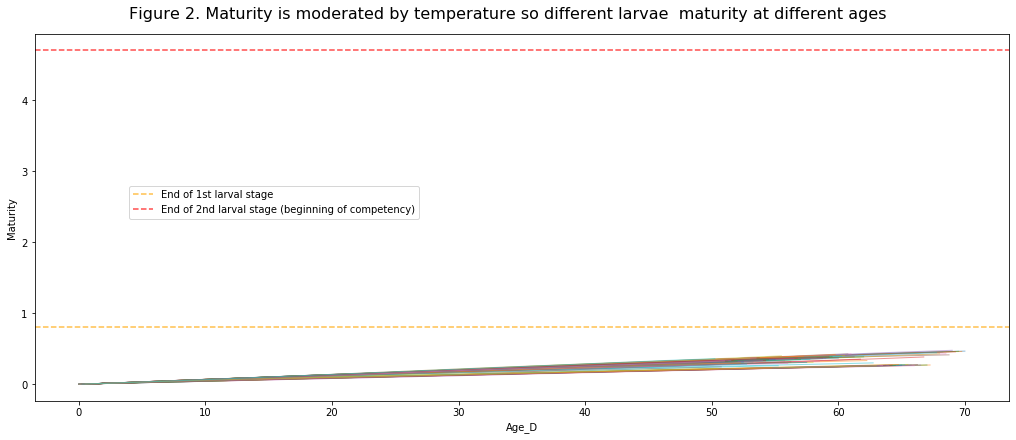

<Figure size 432x288 with 0 Axes>

In [111]:
fig,(ax1) = plt.subplots(figsize=(14,6),constrained_layout=True)

fig.suptitle('Figure 2. Maturity is moderated by temperature so different larvae  maturity at different ages', fontsize=16)

ax1.set_ylabel('Maturity')
ax1.set_xlabel('Age_D')

ax1.plot((traj['age']/86400).T, traj['maturity'].T,linewidth=1, alpha = 0.5,zorder=1)

plt.axhline(y = 0.805986693959648, color = 'orange', linestyle = '--', alpha = 0.7, label = 'End of 1st larval stage')

plt.axhline(y = (3.5/0.6)*0.805986693959648, color = 'red', linestyle = '--', alpha = 0.7, label = 'End of 2nd larval stage (beginning of competency)')


plt.legend(bbox_to_anchor = (0.4, 0.6))

plt.show()
plt.savefig('figures/test_maturity_vs_age_'+runID+'_'+v_name)


In [ ]:
fig,(ax1) = plt.subplots(figsize=(14,6),constrained_layout=True)

fig.suptitle('Figure 2. Maturity is moderated by temperature so different larvae  maturity at different ages', fontsize=16)

ax1.set_ylabel('Maturity')
ax1.set_xlabel('Age_D')

ax1.plot((traj['age']/86400).T, traj['maturity'].T,linewidth=1, alpha = 0.5,zorder=1)



ax1.set_xlim(12, 250)
ax1.set_ylim(4, 6)


plt.axhline(y = 0.805986693959648, color = 'orange', linestyle = '--', alpha = 0.7, label = 'End of 1st larval stage')

plt.axhline(y = (3.5/0.6)*0.805986693959648, color = 'red', linestyle = '--', alpha = 0.7, label = 'End of 2nd larval stage (beginning of competency)')


plt.legend(bbox_to_anchor = (0.4, 0.6))

plt.show()
plt.savefig('figures/test_pacific_maturity_vs_age_m3zoom'+runID+'_'+v_name)


In [ ]:
# Find index of larvae where maturity is above competency threshold

In [ ]:
#select a maturity threshold

m_t = (3.5/0.6)*0.805986693959648

m_thresh = traj.where(traj.maturity<=m_t).squeeze()
m_t

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6),constrained_layout=True)

fig.suptitle('Figure 1. Evolution of depth with maturity and age', fontsize=16)

ax1.set_ylabel('Depth_m')
ax1.set_xlabel('Age_D')

ax1.plot((m_thresh['age']/86400).T, 0-m_thresh['z'].T,linewidth=1, alpha = 0.5,zorder=1)

ax2.set_ylabel('Depth_m')
ax2.set_xlabel('Age_D')

ax2.plot((m_thresh['age']/86400).T, 0-m_thresh['z'].T,linewidth=1, alpha = 0.5,zorder=1)

ax2.set_xlim(75, 200)
ax2.set_ylim(-200, 0)

plt.show()

In [ ]:
xmin = 120
xmax = 150
ymin = 20
ymax = 50

In [ ]:
#filename = "output/pilot2"+str(depc[1])+"m"+v_name+".nc"
#pfile = xr.open_dataset(str(filename), decode_cf=True)
pfile=m_thresh
lon = np.ma.filled(pfile.variables['lon'])
lat = np.ma.filled(pfile.variables['lat'])
time = np.ma.filled(pfile.variables['time'])


central_longitude=30



plottimes = np.arange(time[0,0], np.nanmax(time), np.timedelta64(1, 'D'))
starttime = 0
b = time == plottimes[1+starttime]

In [ ]:
# Select and format a variable by which to colour particles
settle = np.ma.filled(pfile.variables['settle_ID'])
cmap_s=cm.brg(np.array(settle)/np.mean(settle))

maturity = np.ma.filled(pfile.variables['maturity'])
cmap_m=cmocean.cm.speed(np.array(maturity)/np.mean(maturity))




In [ ]:
# Map projection
fig, ax1 = plt.subplots(
    1, 1, figsize=(20, 14),constrained_layout=True)

ax1.set(title="Particle Dispersal: 2D with 50PLD at 1000m")



bathy =ax1.pcolormesh(hgr['glamf'][0],hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep, vmin=0)


#

plottimes = np.unique(time)
#

scat1 = ax1.scatter(lon[b], lat[b], marker='.', s=1000, c='red', linewidth=0.15)


frames = np.arange(0, len(plottimes))

def animate(t):
    b = time == plottimes[t+starttime]
    scat1.set_offsets(np.vstack((lon[b], lat[b],)).transpose())
    #scat1.set_color(cm.Dark2((settle[b])))
    scat1.set_facecolor(cmap_s[b])
    return scat1

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)





anim = animation.FuncAnimation(fig, animate, frames=300, interval=100, blit = False)
HTML(anim.to_jshtml())



In [ ]:
anim.save('figures/test_pacific_ani_'+runID+'_'+v_name+'.mp4')

# PDF and edgelist

Set the terminal location of the particle based on a 'maturity' threshold and settlement encounter

## Aperiodic

In [25]:
pdf = xr.open_dataset("output/run1_p_1_max_b0/pdf_maxSakai.nc")
#pdf = xr.open_dataset("output/run1_tst_pdf_1500m_Sakai.nc")
pdf

<xarray.Dataset>
Dimensions:     (traj: 7440, obs: 1)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
    age         (traj, obs) float32 ...
    settle_ID   (traj, obs) float32 ...
    maturity    (traj, obs) float32 ...
    distance    (traj, obs) float32 ...
    avtemp      (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.2.dev51
    parcels_mesh:           spherical

In [26]:
pdf.distance.values.max()

5298.1855

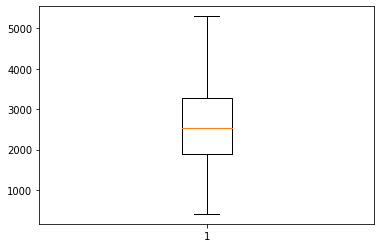

In [27]:
plt.boxplot(pdf.distance.values)
plt.show()

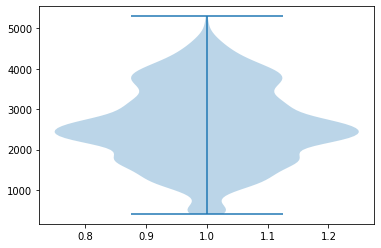

In [28]:
plt.violinplot(pdf.distance.values)
plt.show()

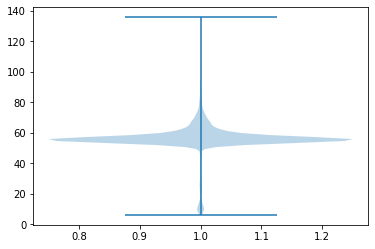

In [35]:
plt.violinplot(pdf.age.values/86400)
plt.show()

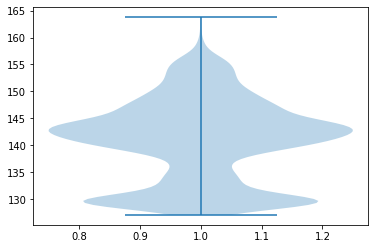

In [29]:
plt.violinplot(pdf.lon.values)
plt.show()

In [30]:
np.where(pdf.settle_ID >=1)

(array([1666, 3981, 4006, 4922, 5537, 7024, 7106]),
 array([0, 0, 0, 0, 0, 0, 0]))

In [31]:
lat3 = np.ma.filled(pdf.variables['lat'], np.nan)
lon3 = np.ma.filled(pdf.variables['lon'], np.nan)
x3 = lon3[~np.isnan(lon3)]
y3 = lat3[~np.isnan(lat3)]
xy3 = np.vstack([x3,y3])
z3 = gaussian_kde(xy3)(xy3)

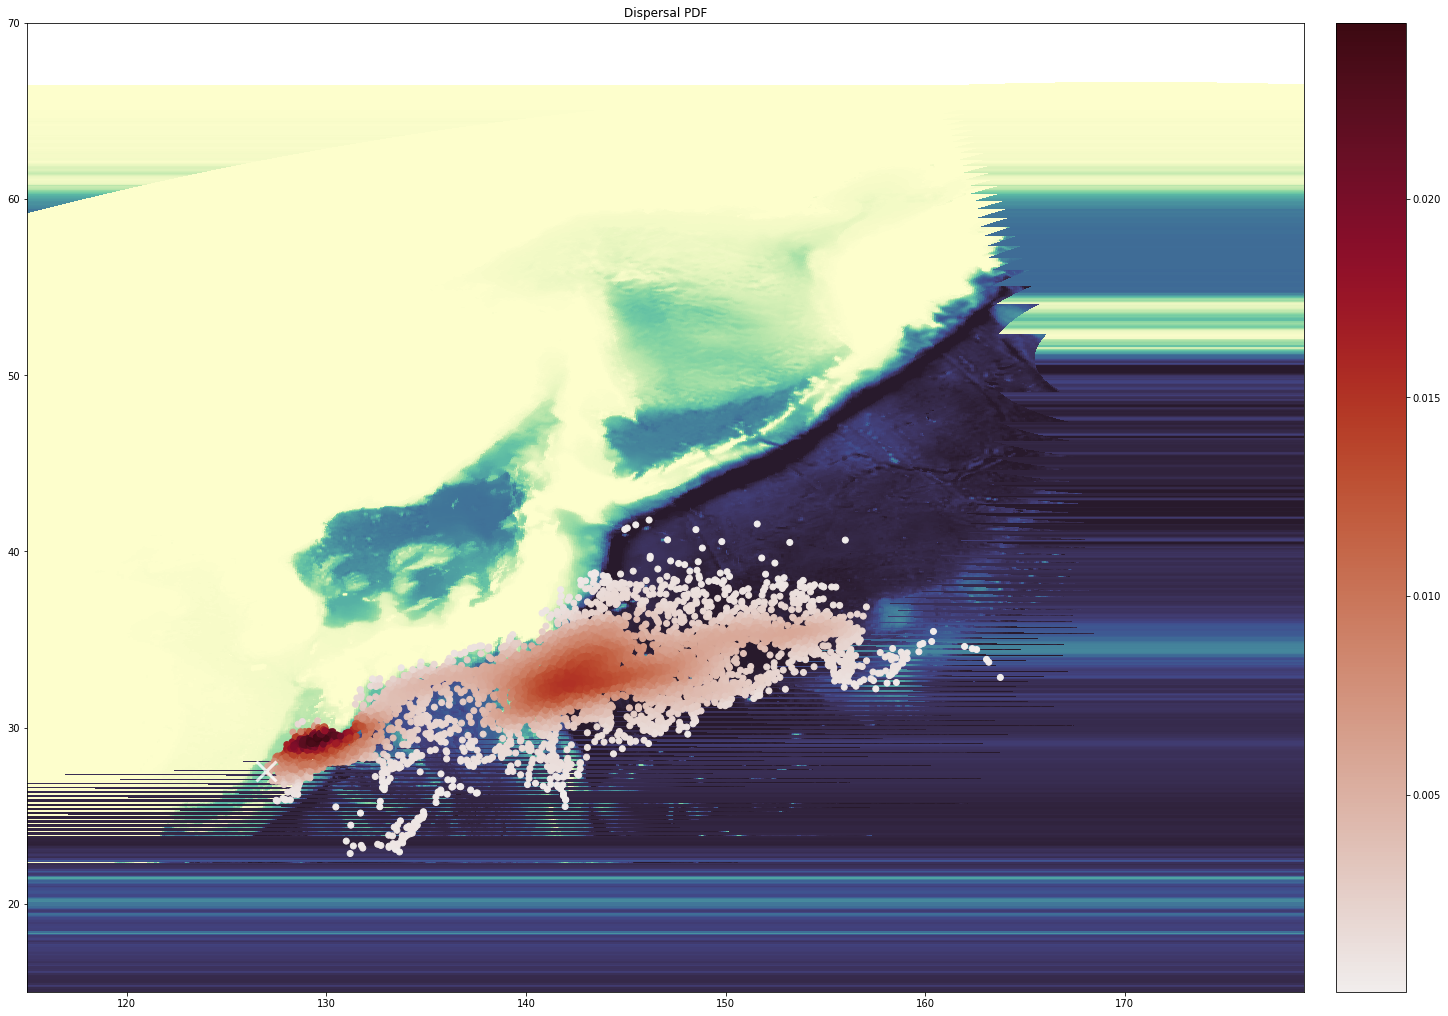

In [33]:


# Map projection
fig, ax = plt.subplots(
    1, 1, figsize=(20, 14),constrained_layout=True)

ax.set(title="Dispersal PDF")


ax.pcolormesh(hgr['glamf'][0],hgr['gphif'][0],zgr['hdepw'][0,:,:].values, cmap=cmocean.cm.deep,zorder=-10)



density = ax.scatter(x3, y3, c=z3, cmap=cmocean.cm.amp)
cbar=plt.colorbar(density)



ax.plot(vent_sites.at[vent_name,'lon'], vent_sites.at[vent_name,'lat'], 
        'x',color="white",zorder=1, alpha =0.8, markersize=20, markeredgewidth = 3)

ax.set_xlim(115, 179)
ax.set_ylim(15, 70)






plt.savefig('figures/run1_b0max_sakai')

plt.show()

In [36]:
pdf.age.values.max()/86400

135.75

In [37]:
pdf.settle_ID.values.max()

62.0

In [ ]:
weight = np.array([])
for i in range(1,37):
    d = list(pdf.settle_ID.values.flatten()).count(i)
    weight= np.append(weight, d)

weight = weight/len(pdf.traj)
frm = np.repeat(vent_sites.index[v],37)
to = vent_sites.index.tolist()
edge_arr= np.array(list(zip(frm, to, weight)))
df = pd.DataFrame(data = edge_arr, 
                  columns = ['Source', 'Target', 'Weight'])
df

In [ ]:
pld = timedelta(seconds = int(pdf.age.values.max()))
pld= str(pld)[0:2]
pld



In [ ]:
maxdep = str(int(pdf.z.values.max()))
maxdep

In [ ]:
df.to_csv('output/test/edges_'+runID+'_'+v_name+'.nc')
